### Data analysis for Full-DIA's result on SC-Cycle dataset

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'

#### Check analysis time

In [2]:
report_dir = Path('../../reports/SC-Cycle')

from datetime import timedelta
with open(report_dir/'full_100'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-1].split(' ')[0][:-1]
    h, m, s = map(int, time_str.split(':'))
    duration = timedelta(hours=h, minutes=m, seconds=s)
    total_minutes = duration.total_seconds()/60.
    n = int(lines[-10].split(' ')[2])
    t_mean = total_minutes / n
print(f'#runs: {n}, Minutes/Run: {t_mean:.2f}')

#runs: 229, Minutes/Run: 12.06


#### Check the report.parquet
1. #ids
2. miss rate

In [3]:
df_raw = pd.read_parquet(report_dir/'full_100'/'report.parquet')
n_pgs = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]['Protein.Group'].nunique()
n_prs = df_raw[df_raw['Global.Q.Value'] < 0.01]['Precursor.Id'].nunique()
print(f'Global n_pgs: {n_pgs}, Global n_prs: {n_prs}')

Global n_pgs: 3007, Global n_prs: 19486


In [4]:
df_raw['PG.Quantity'] = df_raw['PG.Quantity.Deep'].values
df_raw = df_raw[~df_raw['Protein.Group'].str.contains(';')] # groups not in considering

# global FDR filtering
df1 = df_raw[(df_raw['Global.PG.Q.Value'] < 0.01)]
df1 = df1[['Protein.Group', 'Run', 'PG.Quantity']]
df1 = df1.drop_duplicates().reset_index(drop=True)
df1 = df1.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df1.isna().sum().sum() / df1.shape[0] / df1.shape[1]
print(f'Global FDR filtering, shape: {df1.shape}, miss: {miss:.2f}')
df1.columns.name = None
df1.index.name = None
df_protein = df1
df_protein.copy()

Global FDR filtering, shape: (2970, 229), miss: 0.00


,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_01_S3-G2_1_3873,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_02_S3-G3_1_3874,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_03_S3-G4_1_3875,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_04_S3-G5_1_3876,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_05_S3-G6_1_3877,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_06_S3-G7_1_3878,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_10_S3-G11_1_3882,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_11_S3-G12_1_3883,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_15_S3-H5_1_3888,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_17_S3-H7_1_3890,...,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_86_S5-B2_1_4894,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_87_S5-B3_1_4895,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_88_S5-B4_1_4896,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_90_S5-B6_1_4898,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_92_S5-B8_1_4900,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_93_S5-B9_1_4901,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_94_S5-B10_1_4902,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_95_S5-B11_1_4903,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_96_S5-B12_1_4904,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_98_S5-C2_1_4906
A0A024RBG1,4204.475586,9603.109375,4577.289062,6497.609375,12122.803711,9037.748047,3840.789307,8615.324219,10267.246094,5462.425781,...,4133.170898,4261.291992,4188.866699,4055.849365,4173.819336,3689.851074,3748.794189,3596.283691,4084.311523,3922.303223
A0AVT1,4587.321289,10786.529297,5269.217773,7510.305664,14736.810547,10414.132812,4844.937500,9728.530273,10997.609375,5897.169922,...,6819.074219,7212.952637,7313.437012,7511.172852,6978.937988,6092.833008,6363.616211,5877.189453,6790.597656,7105.243164
A0FGR8,7244.734375,22532.964844,8369.985352,13346.962891,29619.537109,21201.027344,7430.455566,19458.199219,22159.410156,9363.628906,...,15064.042969,15832.054688,13741.598633,15466.175781,14704.285156,14267.802734,13014.150391,13488.683594,15022.613281,15567.792969
A0MZ66,5767.237793,13390.673828,6304.032227,8956.821289,17022.546875,12558.124023,5962.736328,11739.643555,13493.134766,7921.172852,...,21518.259766,23255.117188,22250.207031,23872.792969,22110.435547,18757.416016,19187.929688,19132.365234,21350.466797,22238.566406
A1X283,3110.114014,5065.573242,3406.719238,3625.002441,6183.744141,4732.440430,3116.983887,4559.802734,5309.690918,4027.283447,...,6923.228027,7057.729492,7045.684570,7642.216797,6753.096191,5796.864746,6077.412109,6504.696289,6949.014160,7167.350586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6M5,3895.358398,9273.667969,4448.739258,6350.219727,12493.277344,9493.545898,3849.850098,8179.523438,10042.265625,5116.917480,...,4666.710449,4803.809570,4735.753906,4619.316895,4466.197266,4079.134277,4195.922852,4075.409912,4722.024414,4467.223633
Q9Y6N5,3250.284180,6211.108398,3744.242920,4258.623047,7948.470703,6360.489258,3425.521484,5665.075195,6490.619141,4324.252930,...,6772.352051,6471.216797,6764.859863,7726.332031,6458.353027,5726.294434,5873.855469,6247.080078,6766.979980,6957.841797
Q9Y6R0,6959.358887,22483.546875,8237.103516,14502.037109,31262.826172,22101.130859,7675.779297,20446.232422,23196.535156,9294.599609,...,16281.953125,16251.560547,16376.437500,17738.080078,16639.005859,14850.380859,13736.449219,13163.777344,16555.154297,16054.209961
Q9Y6V0,3237.475830,4778.666992,3673.961182,3669.708496,5158.182617,4393.605469,3479.285645,3966.968994,5418.047852,4148.002930,...,9691.760742,10941.333008,10708.257812,12446.770508,10190.945312,9209.483398,9307.399414,10872.898438,10544.898438,10754.673828


#### Convert to cell*protein matrix

In [5]:
df_meta = pd.DataFrame()
df_meta['sample_id'] = 'sample_' + df_raw['Run'].str.split('_').str[-1]
df_meta['treat_id'] = df_raw['Run'].str.split('_').str[-5]
assert set(df_meta['treat_id']) == set(['TB', 'G1', 'G2', 'NB'])
df_meta['treat_id'] = df_meta['treat_id'].replace({'NB': 'G2-M', 'TB': 'G1-S'})
df_meta = df_meta.drop_duplicates().reset_index(drop=True)
df_protein.columns = 'sample_' + df_protein.columns.str.split('_').str[-1]
df_sample = df_protein.T
df_sample = df_sample.merge(df_meta, left_index=True, right_on='sample_id')
df_sample = df_sample.reset_index(drop=True)
df_sample = df_sample[df_sample.columns[::-1]]
df_sample.copy()

,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6R0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K5,...,A6NCN2,A6NCM1,A5YKK6,A4FU69,A3KMH1,A1X283,A0MZ66,A0FGR8,A0AVT1,A0A024RBG1
0,G2-M,sample_3873,6376.411133,3237.475830,6959.358887,3250.284180,3895.358398,4864.062500,5093.817871,3004.363770,...,3825.510742,4914.482422,5470.958008,3811.403564,3878.447021,3110.114014,5767.237793,7244.734375,4587.321289,4204.475586
1,G2-M,sample_3874,17276.062500,4778.666992,22483.546875,6211.108398,9273.667969,8495.365234,15046.986328,5335.330566,...,8204.337891,9386.368164,13799.699219,6230.840820,7074.875000,5065.573242,13390.673828,22532.964844,10786.529297,9603.109375
2,G2-M,sample_3875,7196.092773,3673.961182,8237.103516,3744.242920,4448.739258,5337.531738,5708.312500,3414.579590,...,4055.872803,5344.748047,6456.223633,4064.978516,4329.217285,3406.719238,6304.032227,8369.985352,5269.217773,4577.289062
3,G2-M,sample_3876,11240.758789,3669.708496,14502.037109,4258.623047,6350.219727,6030.519531,9326.529297,3985.822754,...,5765.749023,6331.070312,9352.279297,4675.614258,5291.785156,3625.002441,8956.821289,13346.962891,7510.305664,6497.609375
4,G2-M,sample_3877,22969.570312,5158.182617,31262.826172,7948.470703,12493.277344,9485.384766,20787.117188,6953.934570,...,9956.824219,11111.050781,17660.324219,7782.200195,8417.988281,6183.744141,17022.546875,29619.537109,14736.810547,12122.803711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,15971.011719,9209.483398,14850.380859,5726.294434,4079.134277,20464.384766,5904.002930,3153.777832,...,11796.435547,17997.964844,16976.496094,6211.822754,10233.192383,5796.864746,18757.416016,14267.802734,6092.833008,3689.851074
225,G1,sample_4902,16289.216797,9307.399414,13736.449219,5873.855469,4195.922852,23104.640625,5701.722656,3094.289551,...,13113.801758,19148.148438,18907.613281,6259.173828,10741.716797,6077.412109,19187.929688,13014.150391,6363.616211,3748.794189
226,G1,sample_4903,16391.226562,10872.898438,13163.777344,6247.080078,4075.409912,23764.943359,5327.177246,3041.181641,...,12033.492188,20838.390625,16765.255859,6346.630371,10551.594727,6504.696289,19132.365234,13488.683594,5877.189453,3596.283691
227,G1,sample_4904,18665.972656,10544.898438,16555.154297,6766.979980,4722.024414,22572.380859,6733.102539,3524.117920,...,12772.738281,19992.308594,20055.888672,7124.119141,11223.333984,6949.014160,21350.466797,15022.613281,6790.597656,4084.311523


#### Preprocess
1. drop the high-missingness proteins
2. impute NA with zero
3. normalization
4. log-transformation

##### drop

In [6]:
cut_miss = 0.7
cols_pg = [col for col in df_sample.columns if not col.endswith('_id')]
cols_id = [col for col in df_sample.columns if col.endswith('_id')]
miss_ratio = df_sample[cols_pg].isna().mean()
cols_pg = miss_ratio[miss_ratio <= cut_miss].index.tolist()
df_sample = df_sample[cols_id + cols_pg]
df_sample.copy()

,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6R0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K5,...,A6NCN2,A6NCM1,A5YKK6,A4FU69,A3KMH1,A1X283,A0MZ66,A0FGR8,A0AVT1,A0A024RBG1
0,G2-M,sample_3873,6376.411133,3237.475830,6959.358887,3250.284180,3895.358398,4864.062500,5093.817871,3004.363770,...,3825.510742,4914.482422,5470.958008,3811.403564,3878.447021,3110.114014,5767.237793,7244.734375,4587.321289,4204.475586
1,G2-M,sample_3874,17276.062500,4778.666992,22483.546875,6211.108398,9273.667969,8495.365234,15046.986328,5335.330566,...,8204.337891,9386.368164,13799.699219,6230.840820,7074.875000,5065.573242,13390.673828,22532.964844,10786.529297,9603.109375
2,G2-M,sample_3875,7196.092773,3673.961182,8237.103516,3744.242920,4448.739258,5337.531738,5708.312500,3414.579590,...,4055.872803,5344.748047,6456.223633,4064.978516,4329.217285,3406.719238,6304.032227,8369.985352,5269.217773,4577.289062
3,G2-M,sample_3876,11240.758789,3669.708496,14502.037109,4258.623047,6350.219727,6030.519531,9326.529297,3985.822754,...,5765.749023,6331.070312,9352.279297,4675.614258,5291.785156,3625.002441,8956.821289,13346.962891,7510.305664,6497.609375
4,G2-M,sample_3877,22969.570312,5158.182617,31262.826172,7948.470703,12493.277344,9485.384766,20787.117188,6953.934570,...,9956.824219,11111.050781,17660.324219,7782.200195,8417.988281,6183.744141,17022.546875,29619.537109,14736.810547,12122.803711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,15971.011719,9209.483398,14850.380859,5726.294434,4079.134277,20464.384766,5904.002930,3153.777832,...,11796.435547,17997.964844,16976.496094,6211.822754,10233.192383,5796.864746,18757.416016,14267.802734,6092.833008,3689.851074
225,G1,sample_4902,16289.216797,9307.399414,13736.449219,5873.855469,4195.922852,23104.640625,5701.722656,3094.289551,...,13113.801758,19148.148438,18907.613281,6259.173828,10741.716797,6077.412109,19187.929688,13014.150391,6363.616211,3748.794189
226,G1,sample_4903,16391.226562,10872.898438,13163.777344,6247.080078,4075.409912,23764.943359,5327.177246,3041.181641,...,12033.492188,20838.390625,16765.255859,6346.630371,10551.594727,6504.696289,19132.365234,13488.683594,5877.189453,3596.283691
227,G1,sample_4904,18665.972656,10544.898438,16555.154297,6766.979980,4722.024414,22572.380859,6733.102539,3524.117920,...,12772.738281,19992.308594,20055.888672,7124.119141,11223.333984,6949.014160,21350.466797,15022.613281,6790.597656,4084.311523


##### impute

In [7]:
df_sample = df_sample.fillna(0.)
df_sample.copy()

,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6R0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K5,...,A6NCN2,A6NCM1,A5YKK6,A4FU69,A3KMH1,A1X283,A0MZ66,A0FGR8,A0AVT1,A0A024RBG1
0,G2-M,sample_3873,6376.411133,3237.475830,6959.358887,3250.284180,3895.358398,4864.062500,5093.817871,3004.363770,...,3825.510742,4914.482422,5470.958008,3811.403564,3878.447021,3110.114014,5767.237793,7244.734375,4587.321289,4204.475586
1,G2-M,sample_3874,17276.062500,4778.666992,22483.546875,6211.108398,9273.667969,8495.365234,15046.986328,5335.330566,...,8204.337891,9386.368164,13799.699219,6230.840820,7074.875000,5065.573242,13390.673828,22532.964844,10786.529297,9603.109375
2,G2-M,sample_3875,7196.092773,3673.961182,8237.103516,3744.242920,4448.739258,5337.531738,5708.312500,3414.579590,...,4055.872803,5344.748047,6456.223633,4064.978516,4329.217285,3406.719238,6304.032227,8369.985352,5269.217773,4577.289062
3,G2-M,sample_3876,11240.758789,3669.708496,14502.037109,4258.623047,6350.219727,6030.519531,9326.529297,3985.822754,...,5765.749023,6331.070312,9352.279297,4675.614258,5291.785156,3625.002441,8956.821289,13346.962891,7510.305664,6497.609375
4,G2-M,sample_3877,22969.570312,5158.182617,31262.826172,7948.470703,12493.277344,9485.384766,20787.117188,6953.934570,...,9956.824219,11111.050781,17660.324219,7782.200195,8417.988281,6183.744141,17022.546875,29619.537109,14736.810547,12122.803711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,15971.011719,9209.483398,14850.380859,5726.294434,4079.134277,20464.384766,5904.002930,3153.777832,...,11796.435547,17997.964844,16976.496094,6211.822754,10233.192383,5796.864746,18757.416016,14267.802734,6092.833008,3689.851074
225,G1,sample_4902,16289.216797,9307.399414,13736.449219,5873.855469,4195.922852,23104.640625,5701.722656,3094.289551,...,13113.801758,19148.148438,18907.613281,6259.173828,10741.716797,6077.412109,19187.929688,13014.150391,6363.616211,3748.794189
226,G1,sample_4903,16391.226562,10872.898438,13163.777344,6247.080078,4075.409912,23764.943359,5327.177246,3041.181641,...,12033.492188,20838.390625,16765.255859,6346.630371,10551.594727,6504.696289,19132.365234,13488.683594,5877.189453,3596.283691
227,G1,sample_4904,18665.972656,10544.898438,16555.154297,6766.979980,4722.024414,22572.380859,6733.102539,3524.117920,...,12772.738281,19992.308594,20055.888672,7124.119141,11223.333984,6949.014160,21350.466797,15022.613281,6790.597656,4084.311523


##### normalize

In [8]:
X = df_sample[cols_pg].values
X = 10000 * X / X.sum(axis=1, keepdims=True)
df_sample[cols_pg] = X
df_sample.copy()

,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6R0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K5,...,A6NCN2,A6NCM1,A5YKK6,A4FU69,A3KMH1,A1X283,A0MZ66,A0FGR8,A0AVT1,A0A024RBG1
0,G2-M,sample_3873,2.112541,1.072594,2.305675,1.076837,1.290554,1.611491,1.687611,0.995363,...,1.267413,1.628196,1.812559,1.262740,1.284951,1.030398,1.910718,2.400221,1.519805,1.392966
1,G2-M,sample_3874,1.292182,0.357426,1.681681,0.464567,0.693634,0.635420,1.125455,0.399062,...,0.613652,0.702064,1.032163,0.466042,0.529173,0.378885,1.001570,1.685377,0.806790,0.718275
2,G2-M,sample_3875,1.807221,0.922676,2.068660,0.940326,1.117253,1.340463,1.433581,0.857535,...,1.018589,1.342276,1.621411,1.020875,1.087236,0.855561,1.583190,2.102031,1.323307,1.149537
3,G2-M,sample_3876,1.339025,0.437144,1.727517,0.507297,0.756453,0.718370,1.110998,0.474801,...,0.686830,0.754172,1.114065,0.556970,0.630370,0.431819,1.066957,1.589921,0.894645,0.774010
4,G2-M,sample_3877,1.237162,0.277824,1.683844,0.428112,0.672899,0.510891,1.119613,0.374545,...,0.536283,0.598451,0.951201,0.419156,0.453400,0.333062,0.916850,1.595335,0.793738,0.652945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,2.314963,1.334894,2.152530,0.830014,0.591262,2.966268,0.855772,0.457133,...,1.709867,2.608765,2.460706,0.900390,1.483279,0.840243,2.718846,2.068087,0.883143,0.534836
225,G1,sample_4902,2.705176,1.545695,2.281234,0.975481,0.696824,3.837025,0.946894,0.513874,...,2.177830,3.179964,3.140018,1.039471,1.783894,1.009286,3.186570,2.161281,1.056816,0.622568
226,G1,sample_4903,3.082361,2.044642,2.475441,1.174760,0.766378,4.468984,1.001773,0.571892,...,2.262891,3.918647,3.152696,1.193480,1.984221,1.223204,3.597830,2.536539,1.105202,0.676279
227,G1,sample_4904,2.469296,1.394970,2.190059,0.895195,0.624670,2.986070,0.890713,0.466201,...,1.689688,2.644755,2.653166,0.942440,1.484720,0.919276,2.824424,1.987321,0.898319,0.540308


##### log

In [9]:
df_sample[cols_pg] = np.log2(df_sample[cols_pg] + 1.)
df_sample.copy()

,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6R0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K5,...,A6NCN2,A6NCM1,A5YKK6,A4FU69,A3KMH1,A1X283,A0MZ66,A0FGR8,A0AVT1,A0A024RBG1
0,G2-M,sample_3873,1.638093,1.051437,1.724945,1.054388,1.195697,1.384874,1.426324,0.996651,...,1.181047,1.394073,1.491884,1.178071,1.192163,1.021763,1.541375,1.765629,1.333312,1.258800
1,G2-M,sample_3874,1.196721,0.440873,1.423138,0.550474,0.760122,0.709661,1.087772,0.484460,...,0.690330,0.767285,1.023016,0.551927,0.612752,0.463502,1.001132,1.425125,0.853429,0.780961
2,G2-M,sample_3875,1.489143,0.943115,1.617609,0.956299,1.082194,1.226794,1.283081,0.893389,...,1.013347,1.227911,1.390343,1.014980,1.061594,0.891855,1.369153,1.633213,1.216180,1.104026
3,G2-M,sample_3876,1.225908,0.523205,1.447588,0.591964,0.812665,0.781040,1.077925,0.560520,...,0.754314,0.810790,1.080020,0.638741,0.705199,0.517849,1.047509,1.372908,0.921928,0.827015
4,G2-M,sample_3877,1.161669,0.353690,1.424301,0.514109,0.742350,0.595400,1.083801,0.458954,...,0.619444,0.676675,0.964362,0.505033,0.539432,0.414744,0.938737,1.375921,0.842969,0.725039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,1.728993,1.223357,1.656510,0.871854,0.670171,1.987782,0.892020,0.543133,...,1.438222,1.851505,1.791066,0.926296,1.312246,0.879896,1.894855,1.617339,0.913142,0.618084
225,G1,sample_4902,1.889542,1.348059,1.714239,0.982204,0.762837,2.274120,0.961175,0.598245,...,1.668042,2.063491,2.049637,1.028195,1.477104,1.006683,2.065769,1.660509,1.040413,0.698279
226,G1,sample_4903,2.029403,1.606273,1.797196,1.120856,0.820794,2.451273,1.001278,0.652502,...,1.706151,2.298261,2.054049,1.133222,1.577354,1.152640,2.200953,1.822338,1.073959,0.745262
227,G1,sample_4904,1.794643,1.260008,1.673583,0.922346,0.700147,1.994967,0.918930,0.552083,...,1.427439,1.865822,1.869147,0.957870,1.313083,0.940562,1.935243,1.578852,0.924722,0.623219


#### PCA
- calculating the silhouette score to check the separation

silhouette score: 0.2544


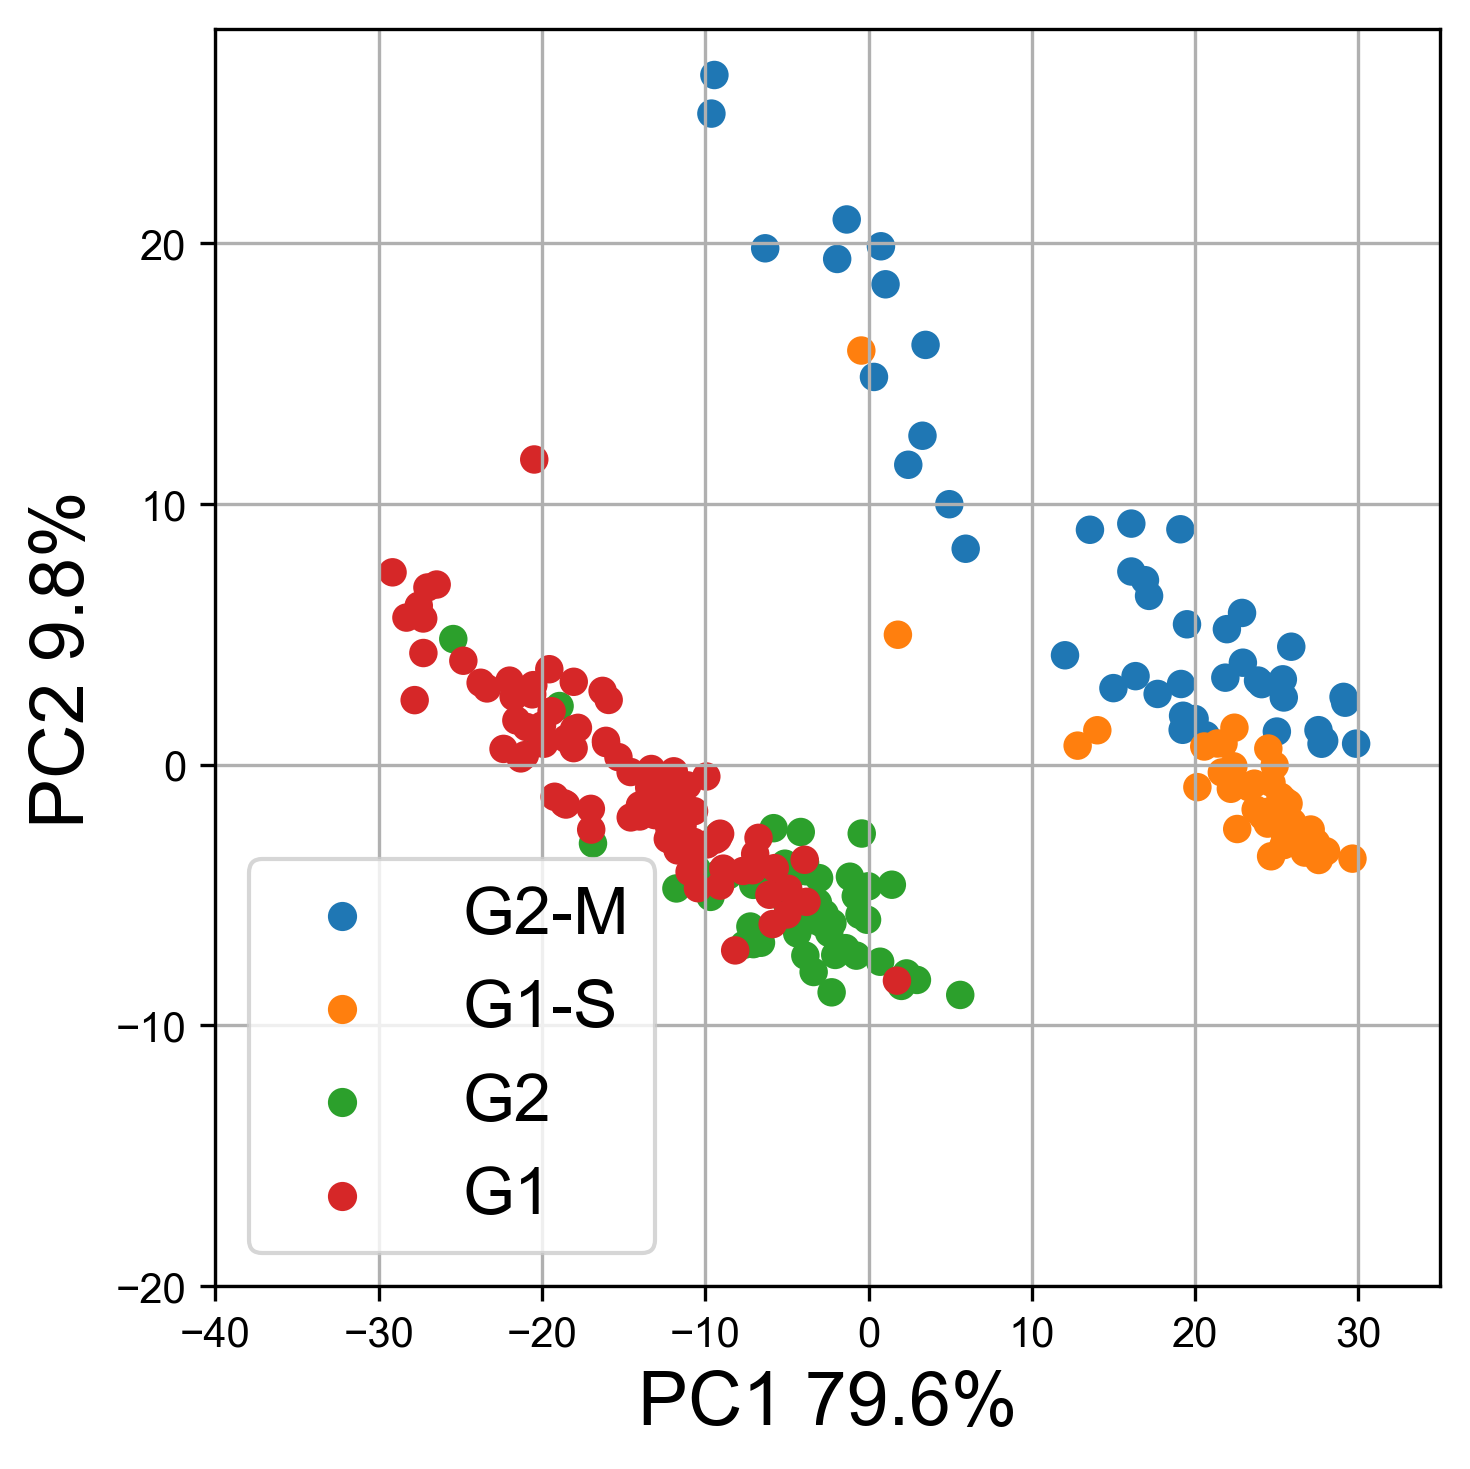

In [10]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

data = df_sample[cols_pg].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

score = silhouette_score(X_pca, df_sample['treat_id'], metric='euclidean')
print(f"silhouette score: {score:.4f}")

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'treat_id': df_sample['treat_id'].values
})

plt.figure(figsize=(5, 5))
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='treat_id', data=df_plot,
    s=40,
    edgecolor=None
)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(-40, 35)
ax.set_ylim(-20, None)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='lower left')
plt.tight_layout()
plt.show()

#### Differential Expression
- G2-M (treat group) vs. G1-S (control group)
- DEP calculation
- Volcano plot

In [11]:
df_sample2 = df_sample[df_sample['treat_id'].isin(['G1-S', 'G2-M'])].reset_index(drop=True)
n_g2m = sum(df_sample2.treat_id == 'G2-M')
n_g1s = sum(df_sample2.treat_id == 'G1-S')
print(f'G2-M #cells: {n_g2m}, G1-S #cells: {n_g1s}')
df_sample2.copy()

G2-M #cells: 45, G1-S #cells: 41


,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6R0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K5,...,A6NCN2,A6NCM1,A5YKK6,A4FU69,A3KMH1,A1X283,A0MZ66,A0FGR8,A0AVT1,A0A024RBG1
0,G2-M,sample_3873,1.638093,1.051437,1.724945,1.054388,1.195697,1.384874,1.426324,0.996651,...,1.181047,1.394073,1.491884,1.178071,1.192163,1.021763,1.541375,1.765629,1.333312,1.258800
1,G2-M,sample_3874,1.196721,0.440873,1.423138,0.550474,0.760122,0.709661,1.087772,0.484460,...,0.690330,0.767285,1.023016,0.551927,0.612752,0.463502,1.001132,1.425125,0.853429,0.780961
2,G2-M,sample_3875,1.489143,0.943115,1.617609,0.956299,1.082194,1.226794,1.283081,0.893389,...,1.013347,1.227911,1.390343,1.014980,1.061594,0.891855,1.369153,1.633213,1.216180,1.104026
3,G2-M,sample_3876,1.225908,0.523205,1.447588,0.591964,0.812665,0.781040,1.077925,0.560520,...,0.754314,0.810790,1.080020,0.638741,0.705199,0.517849,1.047509,1.372908,0.921928,0.827015
4,G2-M,sample_3877,1.161669,0.353690,1.424301,0.514109,0.742350,0.595400,1.083801,0.458954,...,0.619444,0.676675,0.964362,0.505033,0.539432,0.414744,0.938737,1.375921,0.842969,0.725039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,G1-S,sample_4077,0.963338,0.443373,1.010736,0.587870,0.684234,0.652185,0.971207,0.457318,...,0.748541,0.635059,1.140681,0.586496,0.651801,0.473057,0.784410,1.031348,0.688269,0.654945
82,G1-S,sample_4080,0.837908,0.335261,0.902681,0.479696,0.590680,0.522922,0.878039,0.361728,...,0.620348,0.515582,1.005501,0.508897,0.525529,0.388248,0.664459,0.992158,0.579310,0.575640
83,G1-S,sample_4083,0.832276,0.405347,0.896826,0.541107,0.605962,0.614855,0.904621,0.424000,...,0.691042,0.571205,0.999755,0.554186,0.573143,0.441818,0.723341,1.022074,0.610638,0.628094
84,G1-S,sample_4086,0.871544,0.405228,0.954682,0.508423,0.639399,0.590234,0.928221,0.404991,...,0.631389,0.563372,1.026584,0.531472,0.586099,0.429598,0.693364,1.041822,0.596079,0.615928


In [12]:
# calculating: p, adj p, fc
from scipy import stats
import statsmodels.stats.multitest

pvalues = []
protein_names = []
mean_0_v, mean_1_v = [], []
for pg in cols_pg:
    x_treat = df_sample2.loc[df_sample2.treat_id == 'G2-M', pg].values
    x_control = df_sample2.loc[df_sample2.treat_id == 'G1-S', pg].values
    t_val, p_val = stats.ttest_ind(x_treat, x_control, equal_var=False)
    mean_0_v.append(np.mean(x_treat))
    mean_1_v.append(np.mean(x_control))
    pvalues.append(np.float32(p_val))
    protein_names.append(pg)
df_dep = pd.DataFrame({
    'protein_id': protein_names,
    'mean_treat': mean_0_v,
    'mean_control': mean_1_v,
    'pval': pvalues
})
df_dep['pval'] = df_dep['pval'].fillna(np.float32(1))
_, adj_pvals, _, _ = statsmodels.stats.multitest.multipletests(
    df_dep['pval'], alpha=0.05, method="fdr_bh")
df_dep['adj_pval'] = adj_pvals
df_dep['log_fc'] = df_dep['mean_treat'] - df_dep['mean_control']
df_dep.copy()

,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc
0,Q9Y6Y8,1.132329,0.925538,3.295164e-04,4.859303e-04,0.206791
1,Q9Y6V0,0.651389,0.385664,4.542754e-05,7.871633e-05,0.265725
2,Q9Y6R0,1.254346,1.006405,2.595608e-05,4.732324e-05,0.247940
3,Q9Y6N5,0.776627,0.526872,8.242199e-06,1.711841e-05,0.249755
4,Q9Y6M5,0.847243,0.613440,2.156573e-06,5.386897e-06,0.233802
...,...,...,...,...,...,...
2965,A1X283,0.689592,0.418687,3.892050e-06,8.885002e-06,0.270905
2966,A0MZ66,1.058065,0.741626,9.539258e-07,2.727899e-06,0.316440
2967,A0FGR8,1.272912,1.081909,4.261869e-04,6.201740e-04,0.191002
2968,A0AVT1,0.963137,0.609322,8.536126e-10,9.054390e-09,0.353815


In [13]:
# assign up and down
cut_fc, cut_p = 0.2, 0.05
df_dep['state'] = 'none'
idx_up = (df_dep['log_fc'] > cut_fc) & (df_dep['adj_pval'] < cut_p)
idx_down = (df_dep['log_fc'] < -cut_fc) & (df_dep['adj_pval'] < cut_p)
df_dep.loc[idx_up, 'state'] = 'up'
df_dep.loc[idx_down, 'state'] = 'down'
n_neg = sum(df_dep['log_fc'] < 0)
n_pos = sum(df_dep['log_fc'] > 0)
n_down = sum(df_dep['state'] == 'down')
n_up = sum(df_dep['state'] == 'up')
print(f'left area: {n_down}/{n_neg}, right area: {n_up}/{n_pos}')
df_dep.copy()

left area: 135/540, right area: 1558/2430


,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc,state
0,Q9Y6Y8,1.132329,0.925538,3.295164e-04,4.859303e-04,0.206791,up
1,Q9Y6V0,0.651389,0.385664,4.542754e-05,7.871633e-05,0.265725,up
2,Q9Y6R0,1.254346,1.006405,2.595608e-05,4.732324e-05,0.247940,up
3,Q9Y6N5,0.776627,0.526872,8.242199e-06,1.711841e-05,0.249755,up
4,Q9Y6M5,0.847243,0.613440,2.156573e-06,5.386897e-06,0.233802,up
...,...,...,...,...,...,...,...
2965,A1X283,0.689592,0.418687,3.892050e-06,8.885002e-06,0.270905,up
2966,A0MZ66,1.058065,0.741626,9.539258e-07,2.727899e-06,0.316440,up
2967,A0FGR8,1.272912,1.081909,4.261869e-04,6.201740e-04,0.191002,none
2968,A0AVT1,0.963137,0.609322,8.536126e-10,9.054390e-09,0.353815,up


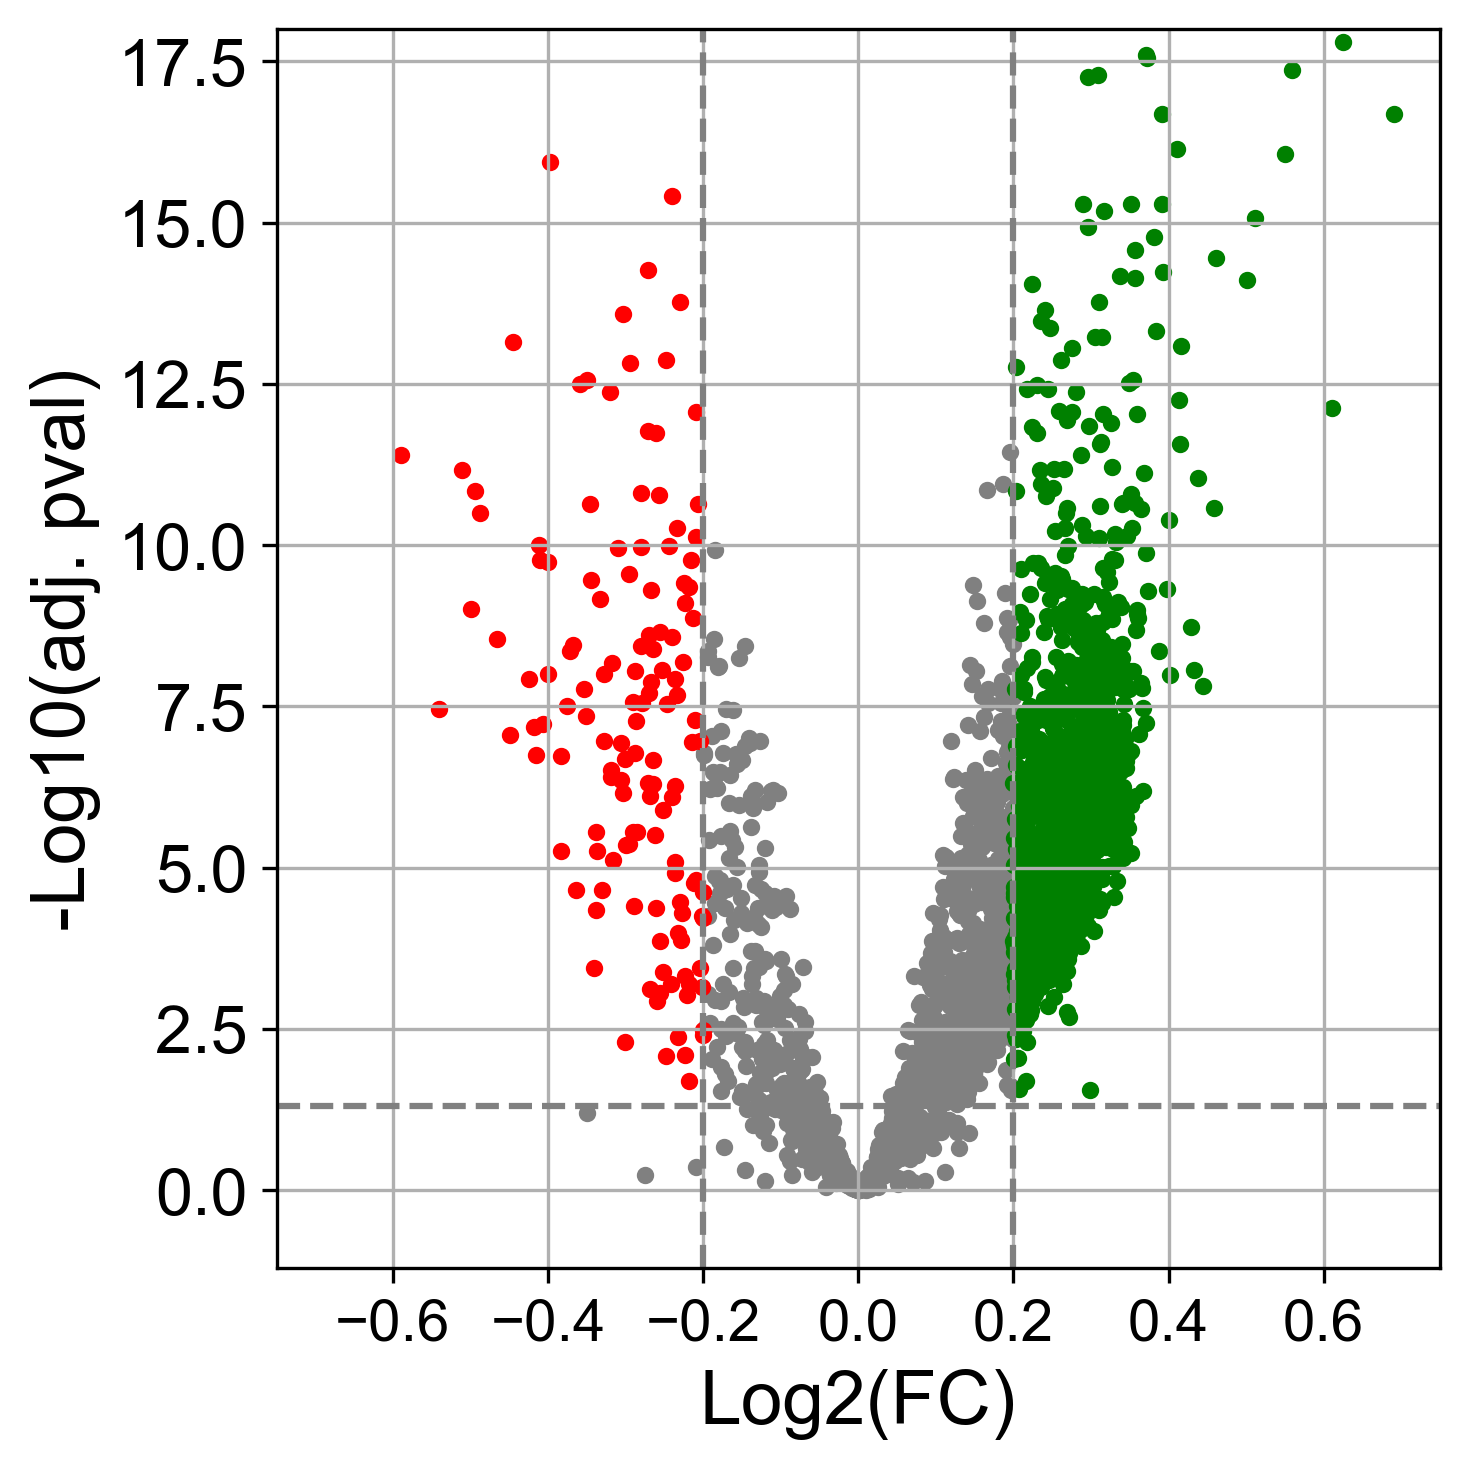

In [14]:
# valcano plot
df_dep['Y'] = -np.log10(df_dep['adj_pval'])
plt.figure(figsize=(5, 5))

df_none = df_dep[df_dep['state'] == 'none']
plt.scatter(x=df_none['log_fc'],
            y=df_none['Y'],
            s=10, label="Not significant", color='grey')

df_up = df_dep[df_dep['state'] == 'up']
df_down = df_dep[df_dep['state'] == 'down']
plt.scatter(x=df_down['log_fc'],
            y=df_down['Y'],
            s=10, color="red")
plt.scatter(x=df_up['log_fc'],
            y=df_up['Y'],
            s=10, color="green")

plt.axvline(cut_fc, color="grey", linestyle="--")
plt.axvline(-cut_fc, color="grey", linestyle="--")
plt.axhline(-np.log10(cut_p), color="grey", linestyle="--")

plt.ylabel("-Log10(adj. pval)", fontsize=18)
plt.xlabel("Log2(FC)", fontsize=18)
plt.xticks(fontweight='light', fontsize=14)
plt.yticks(fontweight='light', fontsize=16)

plt.grid(True)
plt.xlim(-0.75, 0.75)
plt.ylim(None, 18)
plt.tight_layout()
plt.show()

#### Pathway Analysis

In [15]:
# pg --> gene
protein_ids, gene_names, is_isoforms = [], [], []
with open(report_dir/'meta'/'swissprot_UP5640_human_20420_20240619.fasta', 'r') as fasta_file:
    for line in fasta_file:
        line = line.strip()
        if line.startswith(">"):
            protein_id = line.split('|')[1]
            gene_name = None
            for field in line.split():
                if field.startswith("GN="):
                    gene_name = field.split("=")[1]
                    break
            protein_ids.append(protein_id)
            gene_names.append(gene_name)
            is_isoforms.append(line.__contains__('isoform'))
df_map = pd.DataFrame({
    "protein_id": protein_ids, "gene": gene_names
})
df_map = df_map.dropna().reset_index(drop=True)
df_gene = pd.merge(df_dep, df_map, on='protein_id')
df_gene.copy()

,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc,state,Y,gene
0,Q9Y6Y8,1.132329,0.925538,3.295164e-04,4.859303e-04,0.206791,up,3.313426,SEC23IP
1,Q9Y6V0,0.651389,0.385664,4.542754e-05,7.871633e-05,0.265725,up,4.103935,PCLO
2,Q9Y6R0,1.254346,1.006405,2.595608e-05,4.732324e-05,0.247940,up,4.324926,NUMBL
3,Q9Y6N5,0.776627,0.526872,8.242199e-06,1.711841e-05,0.249755,up,4.766536,SQOR
4,Q9Y6M5,0.847243,0.613440,2.156573e-06,5.386897e-06,0.233802,up,5.268661,SLC30A1
...,...,...,...,...,...,...,...,...,...
2965,A1X283,0.689592,0.418687,3.892050e-06,8.885002e-06,0.270905,up,5.051342,SH3PXD2B
2966,A0MZ66,1.058065,0.741626,9.539258e-07,2.727899e-06,0.316440,up,5.564172,SHTN1
2967,A0FGR8,1.272912,1.081909,4.261869e-04,6.201740e-04,0.191002,none,3.207486,ESYT2
2968,A0AVT1,0.963137,0.609322,8.536126e-10,9.054390e-09,0.353815,up,8.043141,UBA6


Mitotic Telophase/Cytokinesis;Metabolism Of RNA;Processing Of Capped Intron-Containing Pre-mRNA;SUMOylation Of DNA Replication Proteins;mRNA Splicing - Major Pathway;mRNA Splicing;Mitotic Anaphase;Mitotic Metaphase And Anaphase;Cell Cycle, Mitotic;mRNA Decay By 3 To 5 Exoribonuclease;Rev-mediated Nuclear Export Of HIV RNA;Transport Of Mature mRNA Derived From An Intronless Transcript;Cohesin Loading Onto Chromatin;Metal Sequestration By Antimicrobial Proteins;Transport Of Mature mRNAs Derived From Intronless Transcripts


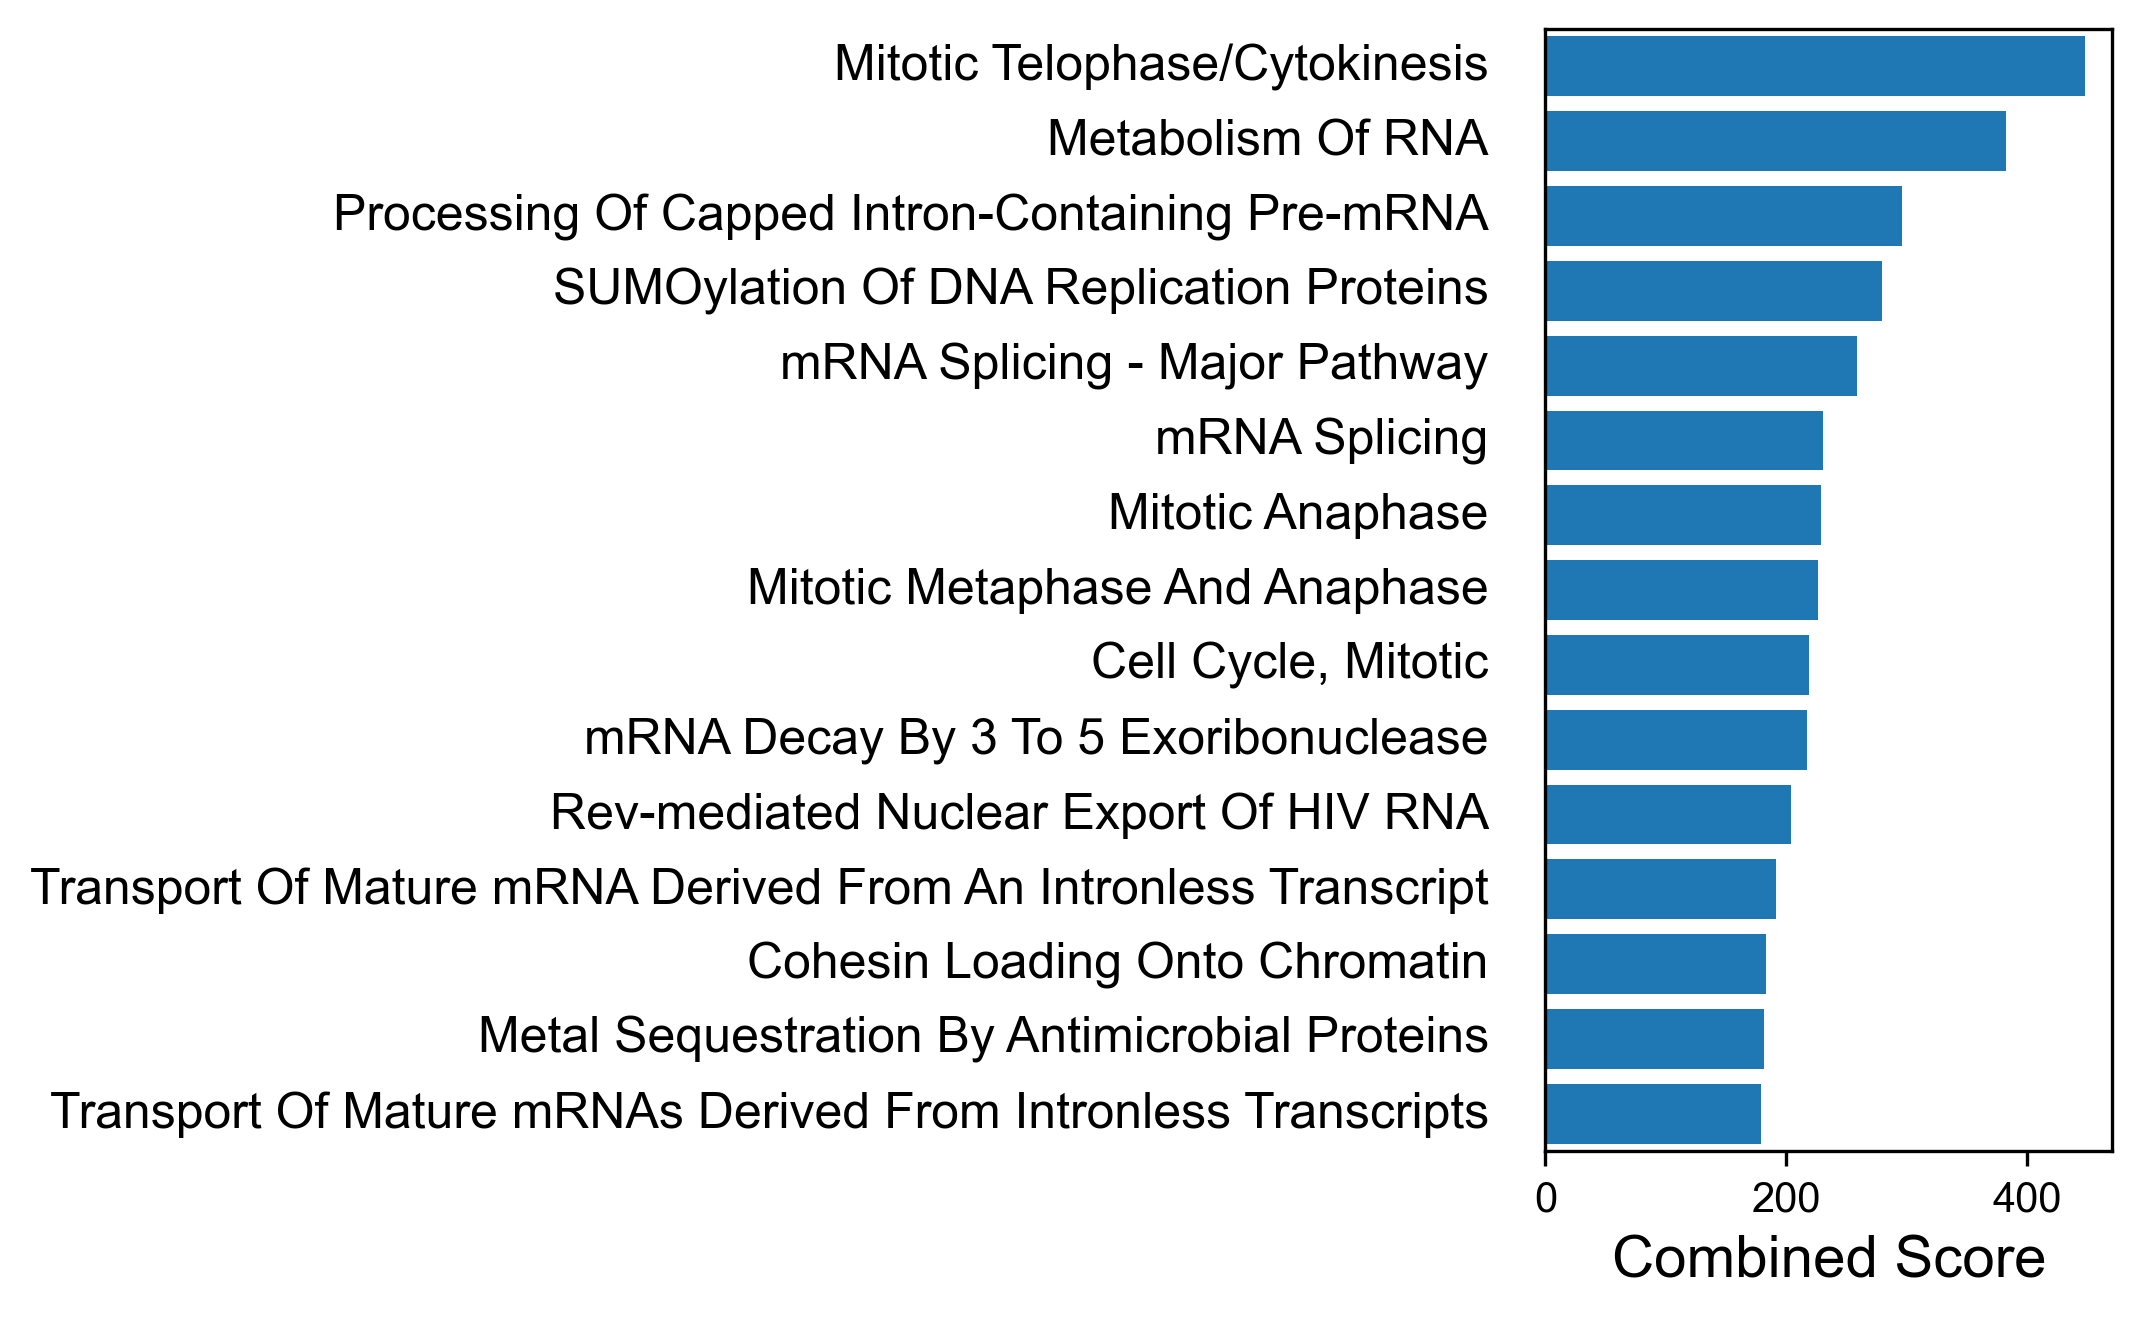

In [16]:
# up pathway enrichment plot
import gseapy as gp
import matplotlib.gridspec as gridspec

n_path = 15

ups = set(df_gene[df_gene['state'] == 'up']['gene'])
enr = gp.enrichr(gene_list=list(ups),
                 gene_sets='Reactome_2022',
                 organism='Human',
                 outdir=None)
df_path = enr.results
df_path = df_path[df_path['Adjusted P-value'] < cut_p]
df_path = df_path.nlargest(n_path, 'Combined Score')

df_path['Term'] = df_path['Term'].str.split(' R-HSA-').str[0]
df_path = df_path.sort_values('Combined Score', ascending=True)
print(df_path['Term'][::-1].str.cat(sep=';'))

terms = df_path['Term'].astype(str).tolist()
scores = df_path['Combined Score'].tolist()
y_pos = np.arange(len(terms))

fig = plt.figure(figsize=(7.5, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

# Left for terms
ax_text = plt.subplot(gs[0])
ax_text.set_xlim(0, 1)
ax_text.set_ylim(-0.5, len(terms) - 0.5)
ax_text.axis('off')
for i, term in enumerate(terms):
    ax_text.text(1.0, i, term, va='center', ha='right', fontsize=12)

# Right for scores
ax_bar = plt.subplot(gs[1])
ax_bar.barh(y_pos, scores)
ax_bar.set_yticks([])
ax_bar.set_ylim(-0.5, len(terms) - 0.5)
ax_bar.set_xlabel('Combined Score', fontsize=14)

plt.tight_layout()
plt.show()